In [ ]:
!pip install kaggle

In [7]:
!kaggle competitions download -c nlp-getting-started

  0%|                                                | 0.00/593k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 10.2MB/s]


In [28]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 12.3 MB/s eta 0:00:00


In [81]:
!pip install spacy -q

In [83]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import spacy
import tensorflow as tf

In [ ]:
sns.set_style("darkgrid")
nltk.download('punkt')

# EDA

In [ ]:
tweets_zip = ZipFile('nlp-getting-started.zip', 'r')
tweets_zip.extractall('data')

In [168]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [169]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [170]:
print(f'There are {train.shape[0]} rows in the train set and {test.shape[0]} rows in the test set')

There are 7613 rows in the train set and 3263 rows in the test set


In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [172]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [173]:
train.drop(columns=['keyword', 'location'], inplace=True)
test.drop(columns=['keyword', 'location'], inplace=True)

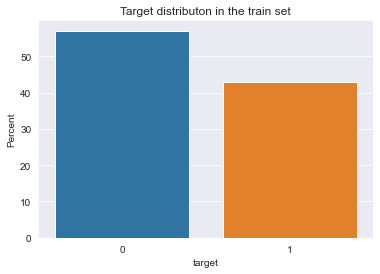

In [41]:
ax = sns.barplot(x='target', y='target', data=train, estimator=lambda x: len(x) / len(train) * 100)
ax.set(ylabel='Percent', title='Target distributon in the train set');

In [50]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

In [51]:
train['count_sentences'] = train['text'].apply(lambda x : len(sent_tokenize(x)))
train['count_words'] = train['text'].apply(lambda x : len(word_tokenize(x)))
train.head(10)

,id,keyword,location,text,target,count_sentences,count_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,14
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,2,8
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,2,24
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,18
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,2,23
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,1,17
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,1,17
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,1,13
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,1,12


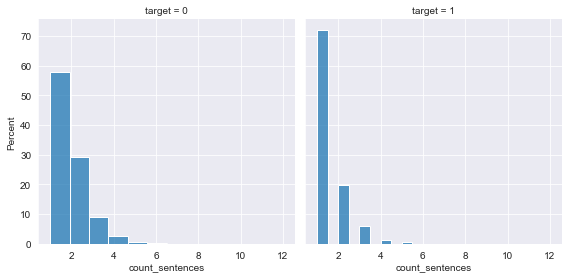

In [65]:
g = sns.FacetGrid(train, col='target', height=4)
g.map(sns.histplot,'count_sentences', bins=12, stat='percent')

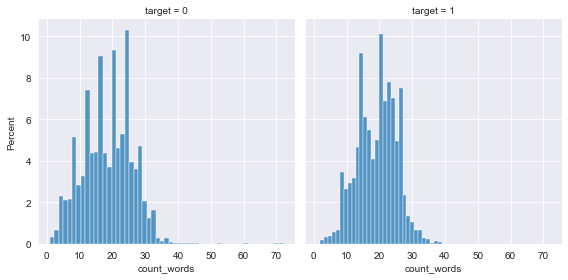

In [64]:
g = sns.FacetGrid(train, col='target', height=4)
g.map(sns.histplot,'count_words', stat='percent')

In [76]:
train_disasters = train[train['target'] == 1]
train_not_disasters = train[train['target'] == 0]

print('For distaster tweets:')
print(f'The mean number of sentences is {round(train_disasters["count_sentences"].mean(),2)} and the median is {train_disasters["count_sentences"].median()}')
print(f'The mean number of words is {round(train_disasters["count_words"].mean(),2)} and the median is {train_disasters["count_words"].median()}')

print('For non distaster tweets:')
print(f'The mean number of sentences is {round(train_not_disasters["count_sentences"].mean(),2)} and the median is {train_not_disasters["count_sentences"].median()}')
print(f'The mean number of words is {round(train_not_disasters["count_words"].mean(),2)} and the median is {train_not_disasters["count_words"].median()}')

For distaster tweets:
The mean number of sentences is 1.4 and the median is 1.0
The mean number of words is 19.26 and the median is 20.0
For non distaster tweets:
The mean number of sentences is 1.6 and the median is 1.0
The mean number of words is 18.66 and the median is 19.0


Disaster tweets are slightly longer

# Preprocessing

In [85]:
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import TweetTokenizer

In [229]:
def preprocess(text):
    #train['text_clean'] = train['text'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==' '))
    text = ''.join(ch for ch in text if ch.isalnum() or ch==' ')
    text = text.lower().strip()
    text = ' '.join([token.lemma_ for token in nlp(text) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    return text

In [183]:
train['text_clean'] = train['text'].apply(lambda x: preprocess(x))
test['text_clean'] = test['text'].apply(lambda x: preprocess(x))

In [182]:
train.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


In [92]:
# Using TweetTokenizer from NLTK instead of TF Tokenizer as it handles better casual language
#tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
#train['text_tokenize'] = train['text_clean'].apply(lambda x : tknzr.tokenize(x))

In [193]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='OOV') # instanciate the tokenizer
tokenizer.fit_on_texts(train['text_clean'])
train['text_encoded'] = tokenizer.texts_to_sequences(train['text_clean'])
test['text_encoded'] = tokenizer.texts_to_sequences(test['text_clean'])
train['len_text'] = train['text_clean'].apply(lambda x: len(x))
train = train[train['len_text']!=0]

In [185]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(train['text_encoded'], padding="post")
text_pad

array([[3654,  413,  173, ...,    0,    0,    0],
       [ 119,    4,  162, ...,    0,    0,    0],
       [1383,  445, 1704, ...,    0,    0,    0],
       ...,
       [2685, 3648, 5509, ...,    0,    0,    0],
       [  24,  740, 2569, ...,    0,    0,    0],
       [ 107,   26,  359, ...,    0,    0,    0]], dtype=int32)

In [186]:
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, train['target']))

In [197]:
# Train Test Split
TAKE_SIZE = int(0.7*train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(100)

val_data = full_ds.skip(TAKE_SIZE)
val_data = val_data.batch(100)

In [188]:
for tweet, target in train_data.take(1):
    print(tweet, target)

tf.Tensor(
[[   1 1285  444 ...    0    0    0]
 [2034  933   41 ...    0    0    0]
 [   3  225 2879 ...    0    0    0]
 ...
 [   1  556 2072 ...    0    0    0]
 [1556   63   61 ...    0    0    0]
 [1281   41 2143 ...    0    0    0]], shape=(100, 25), dtype=int32) tf.Tensor(
[1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0
 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1], shape=(100,), dtype=int64)


In [189]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [190]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 8)             80008     
                                                                 
 global_average_pooling1d_2   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 80,297
Trainable params: 80,297
Non-trainable params: 0
__________________________________________________

In [191]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryCrossentropy()])

In [192]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=50, 
                    validation_data=val_data)

Epoch 1/50
 1/54 [..............................] - ETA: 20s - loss: 0.6931 - binary_crossentropy: 0.6931

2022-09-27 15:50:35.810015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 18ms/step - loss: 0.6859 - binary_crossentropy: 0.6859 - val_loss: 0.6831 - val_binary_crossentropy: 0.6831
Epoch 2/50
 1/54 [..............................] - ETA: 0s - loss: 0.6780 - binary_crossentropy: 0.6780

2022-09-27 15:50:36.811849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 14ms/step - loss: 0.6733 - binary_crossentropy: 0.6733 - val_loss: 0.6777 - val_binary_crossentropy: 0.6777
Epoch 3/50
54/54 [==============================] - 1s 13ms/step - loss: 0.6537 - binary_crossentropy: 0.6537 - val_loss: 0.6528 - val_binary_crossentropy: 0.6528
Epoch 4/50
54/54 [==============================] - 1s 12ms/step - loss: 0.5907 - binary_crossentropy: 0.5907 - val_loss: 0.6054 - val_binary_crossentropy: 0.6054
Epoch 5/50
54/54 [==============================] - 1s 11ms/step - loss: 0.4981 - binary_crossentropy: 0.4981 - val_loss: 0.5517 - val_binary_crossentropy: 0.5517
Epoch 6/50
54/54 [==============================] - 1s 12ms/step - loss: 0.4030 - binary_crossentropy: 0.4030 - val_loss: 0.5150 - val_binary_crossentropy: 0.5150
Epoch 7/50
54/54 [==============================] - 1s 11ms/step - loss: 0.3337 - binary_crossentropy: 0.3337 - val_loss: 0.4942 - val_binary_crossentropy: 0.4942
Epoch 8/50
54/54 [===============

# Prediction

In [224]:
text_pad_test = tf.keras.preprocessing.sequence.pad_sequences(test['text_encoded'], padding="post", maxlen=tweet.shape[1])
test['prediction'] = model.predict(text_pad_test)
test['prediction'] = test['prediction'].apply(lambda x: 1 if x>0.5 else 0)

102/102 [==============================] - 0s 2ms/step


In [228]:
test.head(25)

,id,text,text_clean,text_encoded,prediction
0,0,Just happened a terrible car crash,happen terrible car crash,"[175, 1541, 45, 14]",0
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[126, 173, 935, 121, 369, 1121]",1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[119, 4, 524, 2805, 1, 2096, 381, 98]",1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[388, 3111, 6224, 69]",1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[395, 526, 12, 4189, 340, 939]",1
5,12,We're shaking...It's an earthquake,shakingit earthquake,"[1, 173]",1
6,21,They'd probably still show more life than Arse...,d probably life arsenal yesterday eh eh,"[85, 570, 43, 2131, 1188, 2898, 2898]",0
7,22,Hey! How are you?,hey,[556],0
8,27,What a nice hat?,nice hat,"[971, 598]",0
9,29,Fuck off!,fuck,[139],0
